<a href="https://colab.research.google.com/github/BrunaFerreira/Mestrado_UNIFESP/blob/main/VGG_TL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Bibliotecas a serem utilizadas


In [2]:
import pandas as pd
import tensorflow as tf
import os
import PIL
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os
import shutil
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score

## 1. Copiar arquivos do github para Drive pessoal

In [3]:
'''
Copiar arquivos do repositorio publico
--- Abrir uma pasta no Drive
%cd /content/drive/MyDrive/0_Mestrado_unifesp/3_Pesquisa/Experimentos/Code

--- Clonar repositorio
!git clone --filter=blob:none --no-checkout https://github.com/ArsoVukicevic/Assessment-of-pSS-from-SGUS-images.git
!cp -r  Assessment-of-pSS-from-SGUS-images  /content/drive/MyDrive/0_Mestrado_unifesp/3_Pesquisa/Experimentos/Code/Assessment-of-pSS-from-SGUS-images

'''

'\nCopiar arquivos do repositorio publico\n--- Abrir uma pasta no Drive\n%cd /content/drive/MyDrive/0_Mestrado_unifesp/3_Pesquisa/Experimentos/Code\n\n--- Clonar repositorio\n!git clone --filter=blob:none --no-checkout https://github.com/ArsoVukicevic/Assessment-of-pSS-from-SGUS-images.git\n!cp -r  Assessment-of-pSS-from-SGUS-images  /content/drive/MyDrive/0_Mestrado_unifesp/3_Pesquisa/Experimentos/Code/Assessment-of-pSS-from-SGUS-images\n\n'

## 2. Leitura dos dados (imagens de glandulas salivares)

In [4]:
dir = "/content/drive/MyDrive/0_Mestrado_unifesp/3_Pesquisa/Experimentos/Code/dataset"
df = pd.read_excel(open(dir +'/HarmonicSS_Info.xlsx', 'rb'))
# Renomeia as colunas
df.columns = ['Center','ID','Gland_Type','Machine', 'DeVita_Score', 'Omeract_Score','Sex','Age','Disease_Duration','Label_pSS']
## Retira uma imagem que tem a classificação 2
df = df[df['Label_pSS']!=2]
# Coluna de rótulo convertida para texto
df['Label_pSS'] = df['Label_pSS'].astype(str)
# Inclui zeros a esquerda para o código ID
df['ID'] = df['ID'].apply(lambda x: '{0:0>3}'.format(x))
# Formata o nome do arquivo de cada imagem
df['Image'] = df['ID'].astype(str) + '.jpg'
df_label  = df [['Image','Label_pSS']]
df.head(2)

,Center,ID,Gland_Type,Machine,DeVita_Score,Omeract_Score,Sex,Age,Disease_Duration,Label_pSS,Image
0,Udine (Italy),001,submandibular,samsung,3,3,F,72.0,18,1,001.jpg
1,Udine (Italy),002,parotid,samsung,2,3,F,72.0,18,1,002.jpg


213.jpg


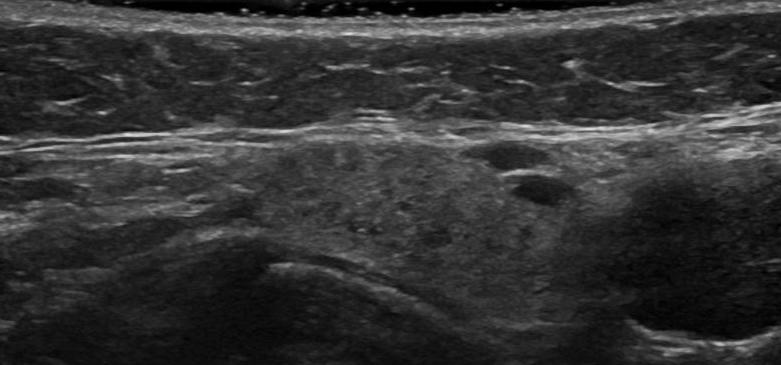

In [5]:
# Exemplo de visualização de uma imagem
img_dir = dir + "/images"
image_extensions = ['.jpg', '.jpeg', '.png']
images = [filename for filename in os.listdir(img_dir) if os.path.splitext(filename)[-1] in image_extensions]
print(images[0])
PIL.Image.open(img_dir + '/' + str(images[0]))

## 3. Pre Processamento

### Separar Treino e Teste

In [6]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split

# Caminhos
origem_imagens = dir+"/images"
destino_base = dir

# Divide em treino/teste mantendo o balanceamento por classe
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['Label_pSS'], random_state=42)

def copiar_imagens(dataframe, tipo):
    for _, row in dataframe.iterrows():
        nome_arquivo = row['Image']
        classe = row['Label_pSS']

        origem = os.path.join(origem_imagens, nome_arquivo)
        if(tipo == 'train'):
          destino_dir = os.path.join(destino_base, tipo, classe)
        else:
          destino_dir = os.path.join(destino_base, tipo)

        os.makedirs(destino_dir, exist_ok=True)
        destino = os.path.join(destino_dir, nome_arquivo)
        shutil.copy2(origem, destino)

# Copiando
copiar_imagens(train_df, 'train')
copiar_imagens(test_df, 'test')

### Pre Processar imagens para usar na VGG

In [7]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_data = ImageFolder(dir + '/train', transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

## Treinamento

### Instancia Modelo

In [8]:
import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modelo VGG16 com pesos pré-treinados
model = models.vgg16(pretrained=True)

# Congela as camadas convolucionais
for param in model.features.parameters():
    param.requires_grad = False

# Substitui o classificador final para 2 classes
model.classifier[6] = nn.Linear(4096, 2)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Treino Modelo

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)

def train(model, loader, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(loader):.4f}")

In [10]:
train(model, train_loader, epochs=5)
#evaluate(model, test_loader)

Epoch [1/5], Loss: 0.5948
Epoch [2/5], Loss: 0.2789
Epoch [3/5], Loss: 0.2276
Epoch [4/5], Loss: 0.1777
Epoch [5/5], Loss: 0.1516


### Inferencia conjunto de teste

In [11]:
from PIL import Image
import numpy as np
# Pasta com imagens
dir_test = dir + "/test"

# Classes (ordem tem que bater com a usada no treinamento)
classes = ['0', '1']

# Guardar resultados
resultados = []

with torch.no_grad():
    for nome_arquivo in os.listdir(dir_test):
        if nome_arquivo.endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp')):
            caminho_imagem = os.path.join(dir_test, nome_arquivo)

            # Abrir imagem e aplicar transform
            imagem = Image.open(caminho_imagem).convert("RGB")
            imagem_tensor = transform(imagem).unsqueeze(0).to(device)

            # Predição
            output = model(imagem_tensor)
            probs = torch.softmax(output, dim=1).cpu().numpy()[0]
            classe_predita = np.argmax(probs)
            conf = probs[classe_predita]

            resultados.append({
                'arquivo': nome_arquivo,
                'label_previsto': classes[classe_predita],
                'probabilidade': conf
            })


In [12]:
previsoes  = pd.DataFrame(resultados)
previsoes.columns = ['Image', 'label_previsto', 'Probability']
result = pd.merge(test_df, previsoes, on="Image", how="left")
result.head()

,Center,ID,Gland_Type,Machine,DeVita_Score,Omeract_Score,Sex,Age,Disease_Duration,Label_pSS,Image,label_previsto,Probability
0,Udine (Italy),027,parotid,samsung,2,3,F,44.000000,13,1,027.jpg,1,0.996599
1,Udine (Italy),059,parotid,samsung,1,2,F,55.000000,6,1,059.jpg,1,0.936688
2,Belgrade (Serbia),206,parotid,GE,3,3,F,68.000000,8,1,206.jpg,1,0.999974
3,Udine (Italy),002,parotid,samsung,2,3,F,72.000000,18,1,002.jpg,1,0.996016
4,Ljubljana (Slovenia),088,submandibular,philips,0,0,F,74.882192,0,0,088.jpg,0,0.521309


### Avaliação

In [13]:
def metricas (df, col_label, col_pred):

  auc = roc_auc_score(df[col_label], df[col_pred])
  f1 = f1_score(df[col_label], df[col_pred])
  acuracia = accuracy_score(df[col_label], df[col_pred])
  precision = precision_score(df[col_label], df[col_pred])
  recall = recall_score(df[col_label], df[col_pred])

  return auc*100, f1*100, acuracia*100, precision*100, recall*100

In [14]:
df_fairness  = pd.DataFrame()
result['Label_pSS'] = result['Label_pSS'].astype(int)
result['label_previsto'] = result['label_previsto'].astype(int)

df_fairness['Base_Completa'] = metricas (result, "Label_pSS", "label_previsto")

## Fairness

### Idade

In [15]:
df_age_ate40 = result[result['Age']<=40]
df_fairness['Idade_Ate40'] = metricas (df_age_ate40, "Label_pSS", "label_previsto")

df_age_mais40 = result[result['Age']>40]
df_fairness['Idade_Mais40'] = metricas (df_age_mais40, "Label_pSS", "label_previsto")

df_fairness

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


,Base_Completa,Idade_Ate40,Idade_Mais40
0,57.051282,NaN,56.904762
1,92.682927,100.0,91.891892
2,86.666667,100.0,85.365854
3,88.372093,100.0,87.179487
4,97.435897,100.0,97.142857


### Sexo

In [16]:
df_sex_F = result[result['Sex']== 'F']
df_fairness['Sexo_F'] = metricas (df_age_ate40, "Label_pSS", "label_previsto")

df_sex_M = result[result['Sex']== 'M']
df_fairness['Sexo_M'] = metricas (df_age_mais40, "Label_pSS", "label_previsto")

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [17]:
df_fairness.set_index(pd.Index(['AUC', 'F1', 'Acuracia', 'Precision', 'Recall']), inplace=True)
df_fairness

,Base_Completa,Idade_Ate40,Idade_Mais40,Sexo_F,Sexo_M
AUC,57.051282,NaN,56.904762,NaN,56.904762
F1,92.682927,100.0,91.891892,100.0,91.891892
Acuracia,86.666667,100.0,85.365854,100.0,85.365854
Precision,88.372093,100.0,87.179487,100.0,87.179487
Recall,97.435897,100.0,97.142857,100.0,97.142857
